In [1]:
library(Seurat)
library(ggplot2)
library(utils)
library(Rmagic)
library(UpSetR)
library(reshape2)
library(patchwork)

Attaching SeuratObject

Seurat v4 was just loaded with SeuratObject v5; disabling v5 assays and
validation routines, and ensuring assays work in strict v3/v4
compatibility mode

Loading required package: Matrix



In [7]:
#The processed Thalamus bin200 files can be downloaded at https://db.cngb.org/stomics/mbcsta/download/
obj_tha <- readRDS('data/obj_tha_b200.rpca.rds')

In [25]:
#The processed segment × genes files can be downloaded at https://db.cngb.org/stomics/mbcsta/download/
obj_segment_gene <- readRDS('data/Segment_genes_marmoset.rds')

In [4]:
#The processed marmoset region × genes files can be downloaded at https://db.cngb.org/stomics/mbcsta/download/
obj_mar_gene <- readRDS('data/region_gene/Region_gene_marmoset.rds')

In [58]:
#The segment border files can be downloaded at https://db.cngb.org/stomics/mbcsta/download/ or https://github.com/haoshijie13/MCCSTA
Border <- read.csv('data/Border.txt')
#The Thalamus border files can be downloaded at https://db.cngb.org/stomics/mbcsta/download/ or https://github.com/haoshijie13/MCCSTA
Border_Tha <- read.csv('data/Tha_Border.txt')

In [6]:
source('R_function/subcortical_related.R')
source('R_function/knn_function.R')
source('R_function/calculate_function.R')

In [62]:
source('R_function/knn_function.R')
source('R_function/subcortical_related.R')
#Smooth Thalamus integrated genes matrix by using smooth_thalamus_integrated from subcortical_related.R
obj_tha <- smooth_thalamus_integrated(obj_tha)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.1 GiB”


  |======================================================================| 100%


In [ ]:
#Caculate Thalamus genes PC1 by using RunPCA
obj_tha@active.assay <- 'imputation'
obj_tha@assays$imputation@var.features <- rownames(obj_tha@assays$imputation)
obj_tha <- ScaleData(obj_tha)
obj_tha <- RunPCA(obj_tha,verbose = F,npcs=30)

In [12]:
source('R_function/knn_function.R')
source('R_function/subcortical_related.R')
#Smooth Thalamus data genes matrix by using smooth_thalamus_data from subcortical_related.R
data_matrix <- smooth_thalamus_data(obj_tha)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 7.2 GiB”


  |======================================================================| 100%


In [13]:
source('R_function/calculate_function.R')
#Calculate correlation between Thalamus genes expression and Thalamus PC1
PC1_cor <- cor_twomatrix(obj_tha@reductions$pca@cell.embeddings[,1,drop = FALSE],t(data_matrix),return.p = T)

  |==================================================================    |  95%

Warning message in cor(x, y):
“the standard deviation is zero”


  |====================================================================  |  97%

Warning message in cor(x, y):
“the standard deviation is zero”


  |===================================================================== |  99%

Warning message in cor(x, y):
“the standard deviation is zero”


  |======================================================================| 100%

Warning message in cor(x, y):
“the standard deviation is zero”


In [14]:
#Combine Thalamus PC1 result with Cortex Pr-AL result
meta.features <- obj_mar_gene[['RNA']]@meta.features[colnames(PC1_cor$R),]
meta.features$tha_PC1 <- as.numeric(PC1_cor$R['PC_1',])
meta.features$tha_PC1_p <- as.numeric(PC1_cor$p.value['PC_1',])
meta.features <- meta.features[!is.na(meta.features$tha_PC1),]
meta.features <- meta.features[!is.na(meta.features$CI),]
meta.features$Tha <- 'Tha-other'
meta.features[meta.features$tha_PC1> 0.1&meta.features$tha_PC1_p<0.05,]$Tha <- 'Tha-P'
meta.features[meta.features$tha_PC1< -0.1&meta.features$tha_PC1_p<0.05,]$Tha <- 'Tha-N'

In [70]:
#Caculate gene-set score of Thalamus PC1 related gene in cortex and Pr-Al related gene in Thalamus
obj_tha@active.assay <- 'imputation'
obj_tha <- AddModuleScore(obj_tha,features = list('Pr'=rownames(meta.features)[meta.features$type=='Pr']),name='Pr',slot='data',assays='imputation',verbose=FALSE)
obj_tha <- AddModuleScore(obj_tha,features = list('Al'=rownames(meta.features)[meta.features$type=='Al']),name='Al',slot='data',assays='imputation',verbose=FALSE)
obj_segment_gene <- AddModuleScore(obj_segment_gene,features = list('Tha-P'=rownames(meta.features)[meta.features$Tha=='Tha-P']),name='Tha-P',slot='data',assays='RNA')
obj_segment_gene <- AddModuleScore(obj_segment_gene,features = list('Tha-N'=rownames(meta.features)[meta.features$Tha=='Tha-N']),name='Tha-N',slot='data',assays='RNA')

Warning message:
“The following features are not present in the object: LOC108593583, SUPT6H, LOC108593711, PHC2, PAXBP1, MZT1, F5, SMPD3, SERINC5, CC2D1B, HEY2, TARBP1, CENPC, LOC103791986, MFSD14B, PRKDC, TRIP10, HMMR, LOC118155256, MYBPH, WRAP53, CKAP4, PDK1, FMO5, PWWP2A, ITPK1, LOC118154000, IL2RB, PTGES3L, ADAMTS20, SAMD1, LOC118153865, SLC31A2, SBNO2, LOC108590783, IRF2, C3H4orf46, DCAF16, LOC103793595, DCDC2B, BAK1, HIBCH, TSC1, LOC108590276, HSD17B1, LOC103793092, LOC103793395, HINFP, DEFB1, PAOX, LOC118146731, GRIPAP1, CABYR, C14H2orf68, TMEM150A, FSHR, FN3K, NUP93, LOC108588849, IFFO1, RNFT2, PRKAR1A, ECM1, LOC118149328, LOC118149560, C20H16orf86, SIRT6, TMEM86B, LOC103787459, ND5, LOC103795757, TSPAN3, PTGS1, MYBPC1, LOC103792480, LOC103788289, LOC118144235, OLIG2, ZNF500, MTF1, DCT, LOC108591660, ANO7, LOC100390841, EPB41L2, LOC118152311, HIPK2, ZBTB43, ATP6V1C2, LOC118143131, FBXO32, LOC118143680, CTDSP2, CCDC27, MAFB, PLEKHN1, LOC118155308, PCED1A, KIAA0586, MEPCE, LOC10

,Pr-Al-Index,Tha-P1,Tha-N1
Pr-Al-Index,1.0000000,0.8950301,-0.9111883
Tha-P1,0.8950301,1.0000000,-0.9693018
Tha-N1,-0.9111883,-0.9693018,1.0000000


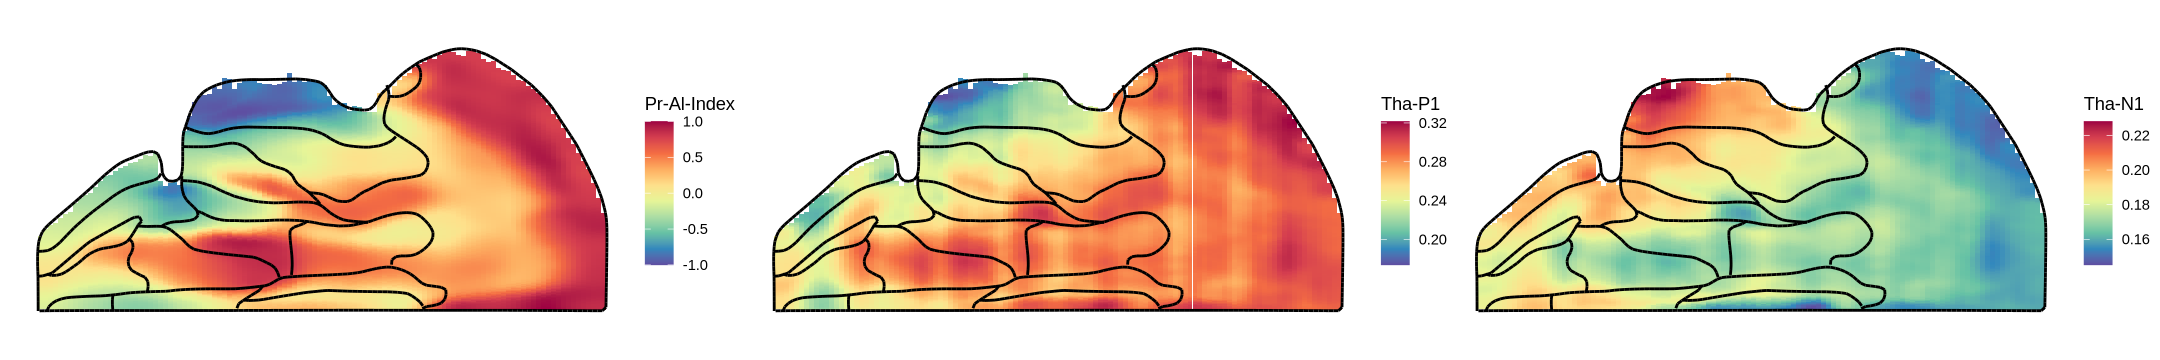

In [114]:
source('R_function/segment_plot.R')
options(repr.plot.width=18,repr.plot.height=3)
#Plot gene-set score of Thalamus PC1 related gene and Pr-Al Index
plot_col_exp(obj_segment_gene@meta.data,col_exp = 'Pr-Al-Index',border = T,border_use = Border)+
plot_col_exp(obj_segment_gene@meta.data,col_exp = 'Tha-P1',border = T,border_use = Border)+
plot_col_exp(obj_segment_gene@meta.data,col_exp = 'Tha-N1',border = T,border_use = Border)
cor(obj_segment_gene@meta.data[,c('Pr-Al-Index','Tha-P1','Tha-N1')])

,Gene-PC1,Pr1,Al1
Gene-PC1,1.00,0.93,-0.94
Pr1,0.93,1.00,-0.96
Al1,-0.94,-0.96,1.00


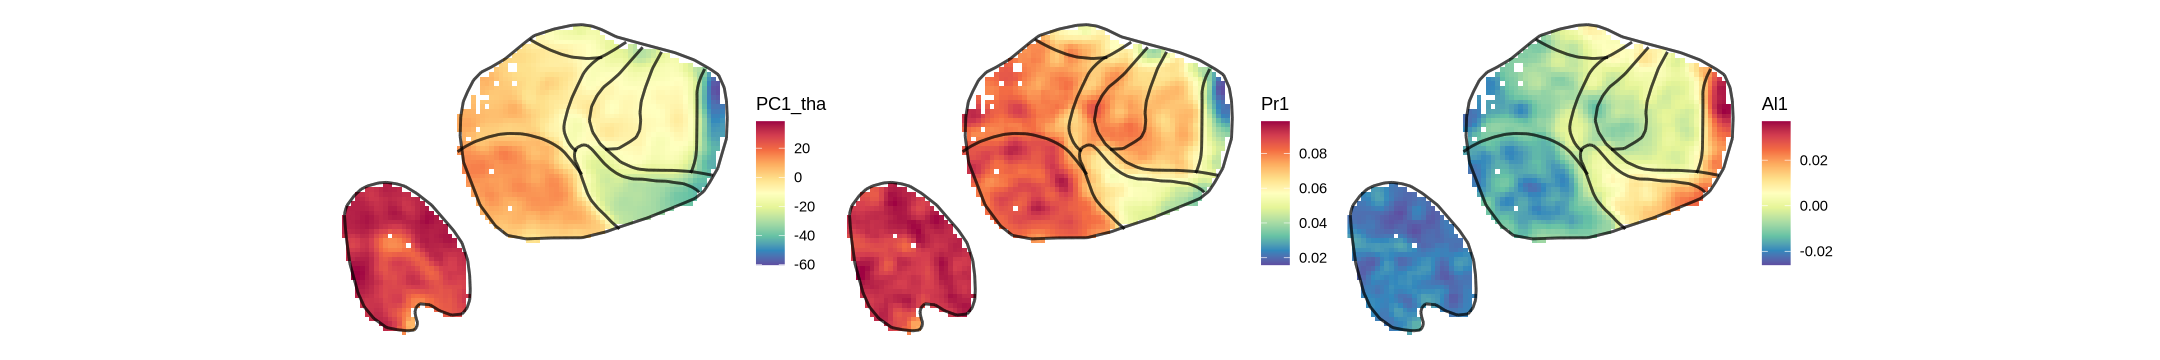

In [72]:
source('R_function/ST_plot.R')
obj_tha$`PC1_tha` <- obj_tha@reductions$pca@cell.embeddings[,1]
options(repr.plot.width=18,repr.plot.height=3)
#Plot gene-set score of Pr-Al Index related gene and thalamic gene PC1
plot_spatial_col(obj_tha@meta.data[obj_tha$sample=='T462',],'PC1_tha',border = T,border_use = Border_Tha)+
plot_spatial_col(obj_tha@meta.data[obj_tha$sample=='T462',],'Pr1',border = T,border_use = Border_Tha)+
plot_spatial_col(obj_tha@meta.data[obj_tha$sample=='T462',],'Al1',border = T,border_use = Border_Tha)
round(cor(obj_tha@meta.data[,c('Gene-PC1','Pr1','Al1')]),2)

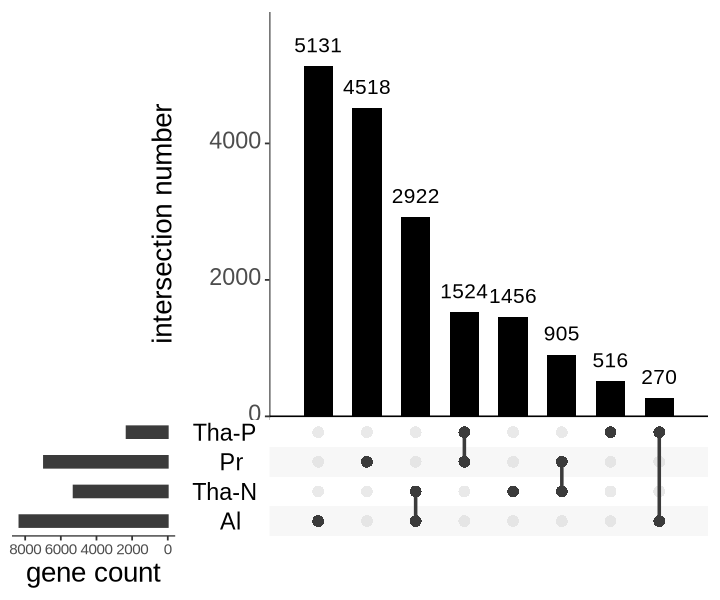

In [15]:
#Calculated intersection of four gene-set
plot_subcortical_upset(meta.features)

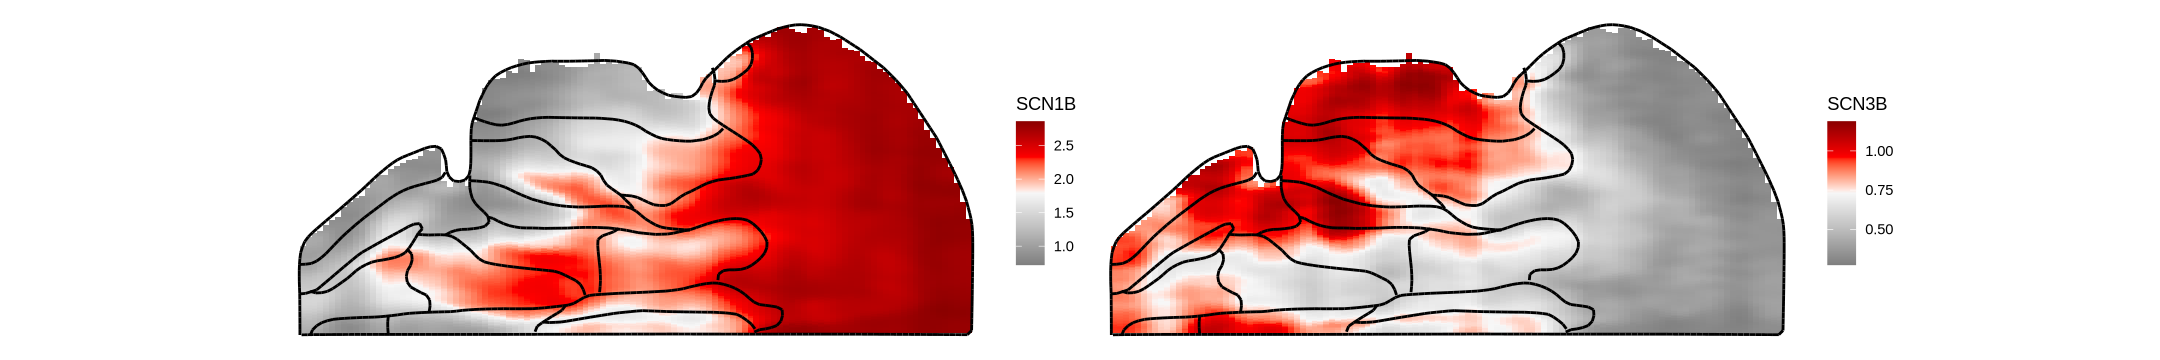

In [111]:
source('R_function/ST_plot.R')
options(repr.plot.width=18,repr.plot.height=3)
plot_features(obj_segment_gene,features = 'SCN1B',assays='RNA',slot='data',color = c('gray50','gray','gray97','red','darkred'))+
plot_features(obj_segment_gene,features = 'SCN3B',assays='RNA',slot='data',color = c('gray50','gray','gray97','red','darkred'))

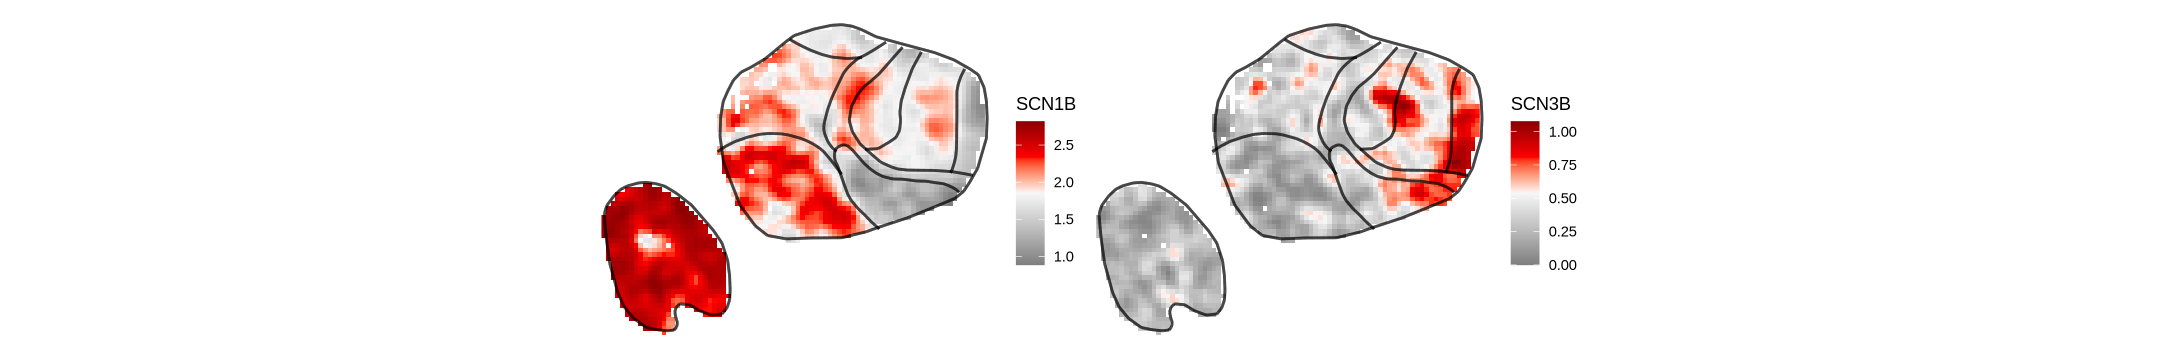

In [112]:
source('R_function/segment_plot.R')
options(repr.plot.width=18,repr.plot.height=3)
plot_spatial_feature(obj_tha[,obj_tha$sample=='T462'],'SCN1B',assays = 'RNA',slot = 'data',border = T,border_use = Border_Tha,smooth=T,knn=9)+
plot_spatial_feature(obj_tha[,obj_tha$sample=='T462'],'SCN3B',assays = 'RNA',slot = 'data',border = T,border_use = Border_Tha,smooth=T,knn=9)